In [1]:
# Import packages
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

In [4]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [5]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [6]:
lsbg_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_2000.fits')
# lsbg_cat['image_flag'] = np.ones(len(lsbg_cat), dtype=bool)
# lsbg_cat['psf_flag'] = np.ones(len(lsbg_cat), dtype=bool)
print('# of LSBGs:', len(lsbg_cat))
channels = 'griz'

# of LSBGs: 2000


In [11]:
np.sum(~np.all(lsbg_cat['image_flag'], axis=1))

25

In [20]:
lsbg = lsbg_cat[3] # 12 # 69

In [21]:
lsbg

<Row index=3>
viz-id         ra                dec             mag_auto_i         sersic_n          sersic_ell         sersic_PA     sersic_rhalf_circ               sersic_sed [4]                             mags [4]                           prefix           image_flag [4] psf_flag [4]
int64       float64            float64            float64           float64            float64            float64           float64                       float64                                 float64                           bytes65                bool          bool    
------ ------------------ ------------------ ----------------- ------------------ ------------------ ----------------- ------------------ ---------------------------------------- -------------------------------------- --------------------------- -------------- ------------
     3 30.502383508854994 -5.472485951920646 20.30446687582183 0.8615599618775095 0.3678697434415449 54.86953945683956 5.2441005980435795 0.48053317470040924 .. 1.020012888335637 21.10015843695514 .. 20.28295272755016 ./Cutout/mock_sample/mock_3   True .. True True .. True

### Running scarlet wavelet modeling for `./Cutout/mock_sample/mock_3`
    Working directory: /scratch/gpfs/jiaxuanl/Data/HSC/LSBG
  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    6 stars from Gaia are masked!
    Detected 334 objects
    6 stars from Gaia are masked!
    Detected 248 objects
    Detected 132 objects
  - Wavelet modeling with the following hyperparameters:
    min_grad = 0.02, starlet_thresh = 1.00 (contam_ratio = 0.10), 
     monotonic = True, variance = 0.00250, scales = [0, 1, 2, 3, 4, 5, 6].
    Total number of sources: 5
  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 53 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 93 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 113 iterations! Try higher accuracy!
  - After 113 iterations, logL = 2342284.30
    Elapsed time for fitting: 73.91 s
  - Components [0] ar

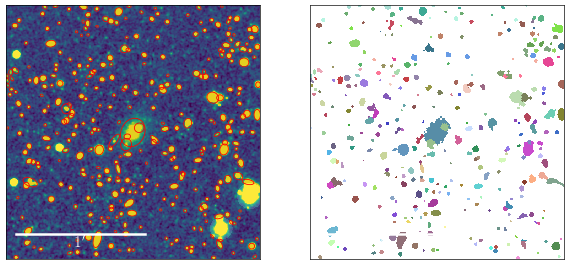

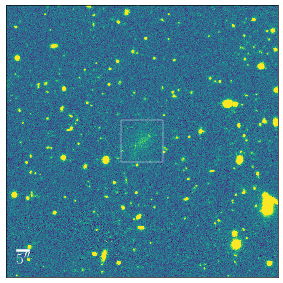

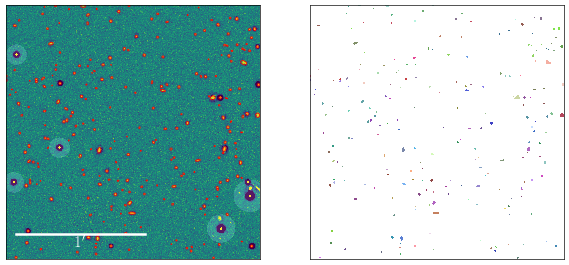

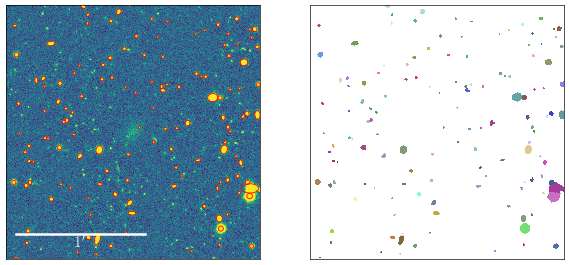

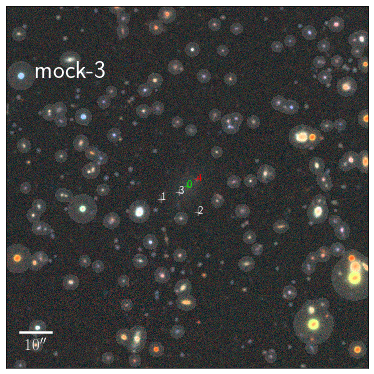

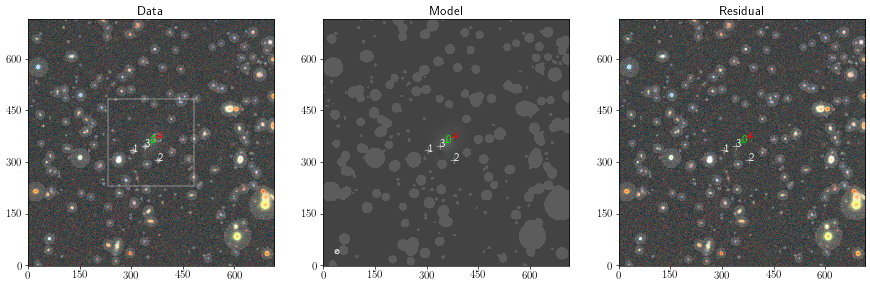

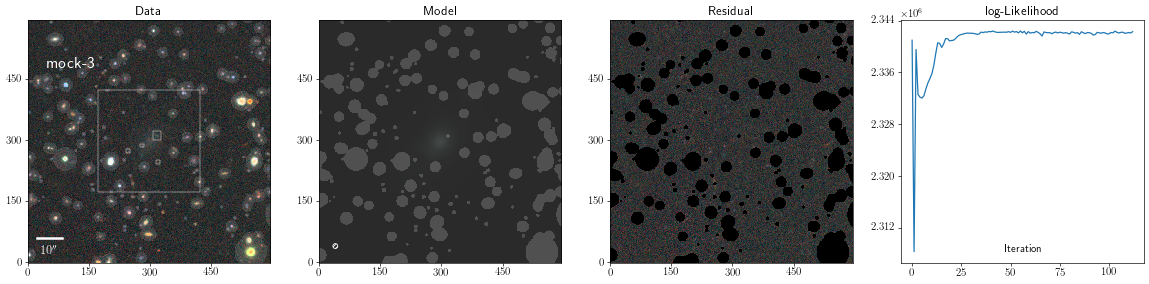

In [22]:
fitting_obs_tigress(env_dict, 
                    lsbg, 
                    name='viz-id',
                    method='wavelet', 
                    starlet_thresh=1,
                    monotonic=True,
                    variance=0.05**2,
                    scales=[0, 1, 2, 3, 4, 5, 6],
                    prefix='mock', 
                    model_dir='./Model/mock_sample/',
                    figure_dir='./Figure/mock_sample',
                    log_dir='./log/mock_sample',
                    show_figure=True)

In [186]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = True


In [219]:
fitter = ScarletFitter(method='wavelet', tigress=True, 
                       starlet_thresh=1.0, 
                       monotonic=True, variance=0.05**2, 
                       scales=[0, 1, 2, 3, 4, 5, 6],
                       model_dir='./Model/mock_sample/',
                       figure_dir='./Figure/mock_sample',
                       log_dir='./log/mock_sample',
                       prefix='mock', 
                       index=lsbg['viz-id'], 
                       show_figure=True)
fitter.load_data(data, lsbg_coord)

  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    1 stars from Gaia are masked!
    Detected 66 objects
    1 stars from Gaia are masked!
    Detected 69 objects
    Detected 38 objects
    Total number of sources: 52
  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 80 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 120 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 140 iterations! Try higher accuracy!
  - After 74 iterations, logL = 1318753.37
    Elapsed time for fitting: 132.30 s
  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/mock_sample/mock-69-trained-model-vanilla.df


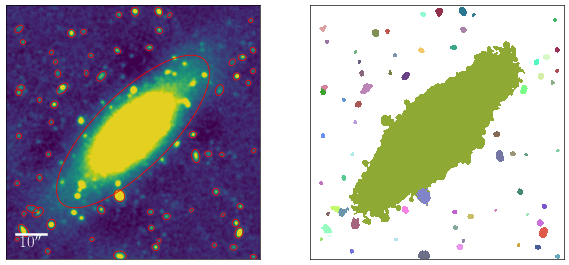

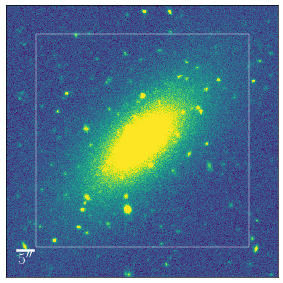

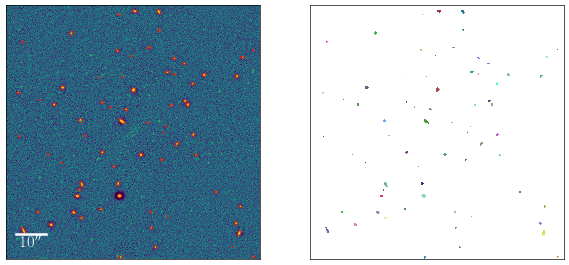

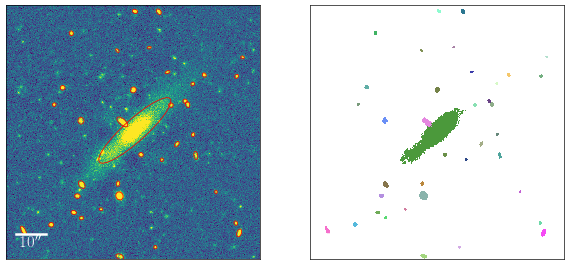

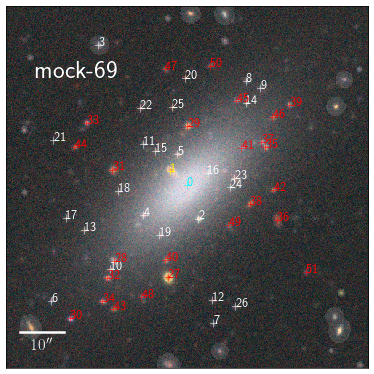

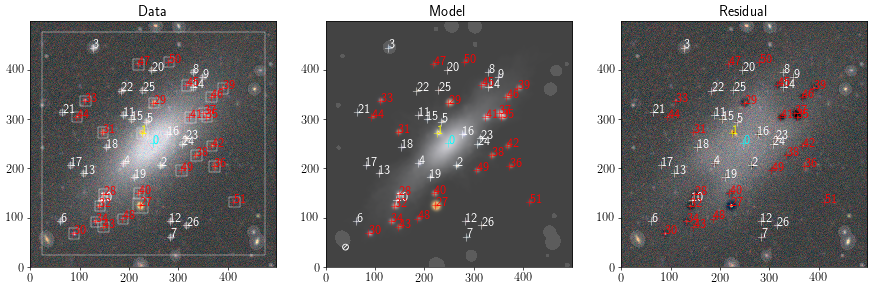

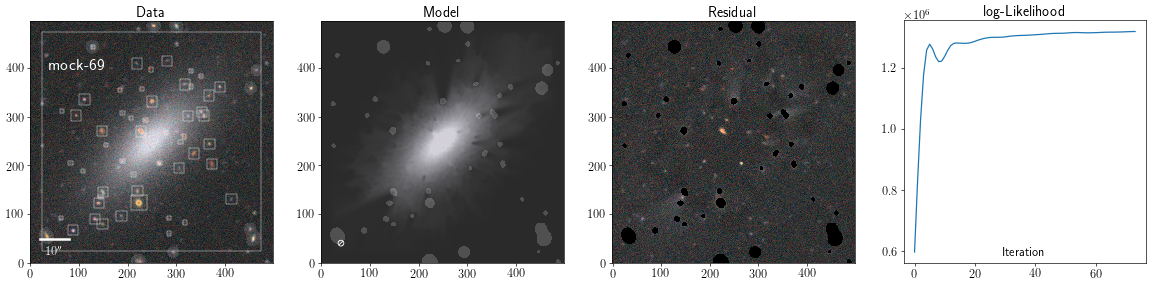

In [220]:
fitter.fit()

#### Step-by-step

In [100]:
fitter._first_gaia_search()

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    3 stars from Gaia are masked!


In [101]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0

    Detected 170 objects


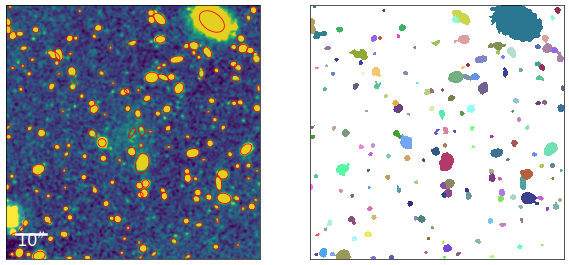

In [102]:
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.006

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002
        
fitter._first_detection(first_dblend_cont)

In [103]:
import scarlet.initialization as init

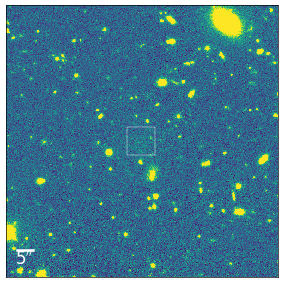

In [104]:
fitter._estimate_box(fitter.cen_obj)

In [105]:
fitter._mask_stars_outside_box()

    3 stars from Gaia are masked!


    Detected 135 objects


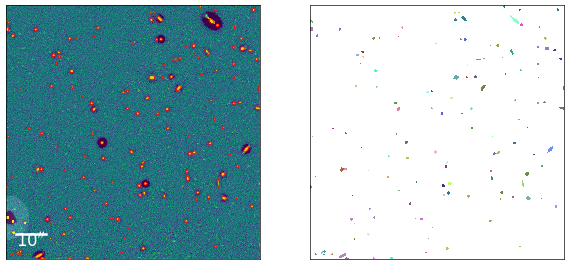

In [106]:
fitter._cpct_obj_detection()

In [107]:
from kuaizi.display import draw_circles

    Detected 64 objects


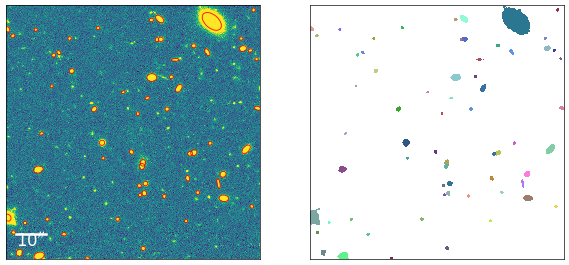

In [108]:
fitter._big_obj_detection()

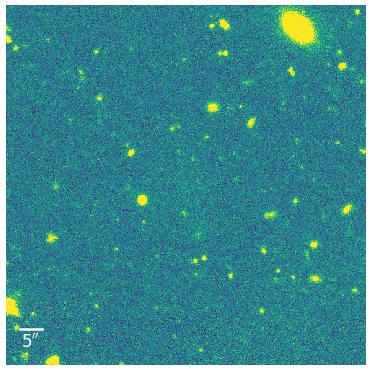

In [109]:
draw_circles(fitter.data.images[0], fitter.obj_cat_big)

In [110]:
fitter._merge_catalogs()

In [111]:
fitter._construct_obs_frames()

In [112]:
fitter.monotonic = True
fitter.variance = 0.05**2
fitter.scales = [0, 1, 2, 3, 4, 5]
fitter.starlet_thresh = 1

In [113]:
fitter._add_sources(min_grad=0.02)

  - Wavelet modeling with the following hyperparameters:
    min_grad = 0.02, starlet_thresh = 1.00 (contam_ratio = 0.11), 
 monotonic = True, variance = 0.0025000000000000005, scales = [0, 1, 2, 3, 4, 5].
    Total number of sources: 1


[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

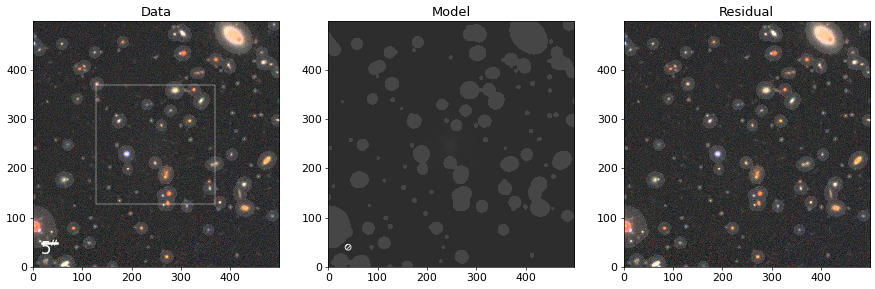

In [114]:
kz.display.display_scarlet_model(
    fitter.blend,
    #show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=False)

In [115]:
# fitter.blend.fit(10)

    Optimizaiton: Succeed for e_rel = 0.0001 with 48 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 88 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 108 iterations! Try higher accuracy!
  - After 80 iterations, logL = 1215334.52
    Elapsed time for fitting: 43.99 s


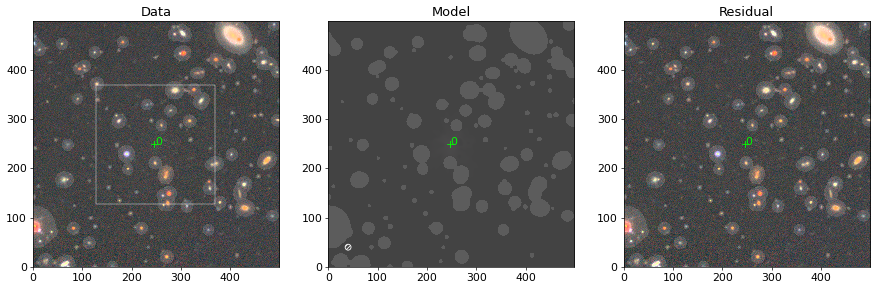

In [116]:
try:
    fitter._optimize()
#     fitter._optimize()
except:
    pass

In [117]:
try:
    fitter._find_sed_ind()
    fitter._gen_final_mask()
except:
    pass

  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/mock_sample/mock-164-trained-model-wavelet.df


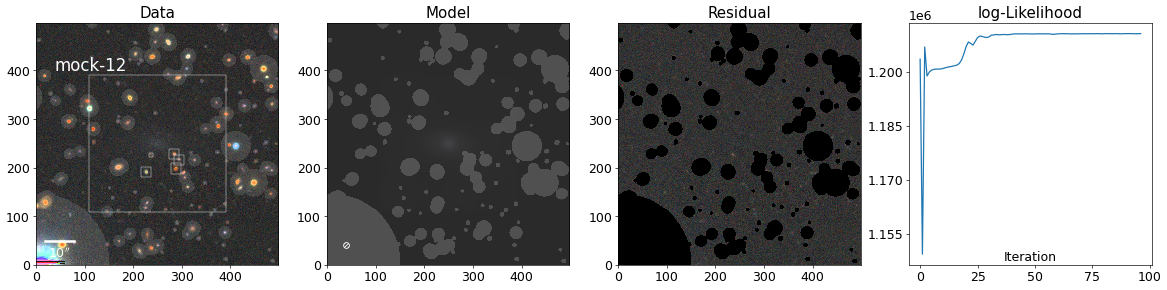

In [145]:
fitter._display_results()

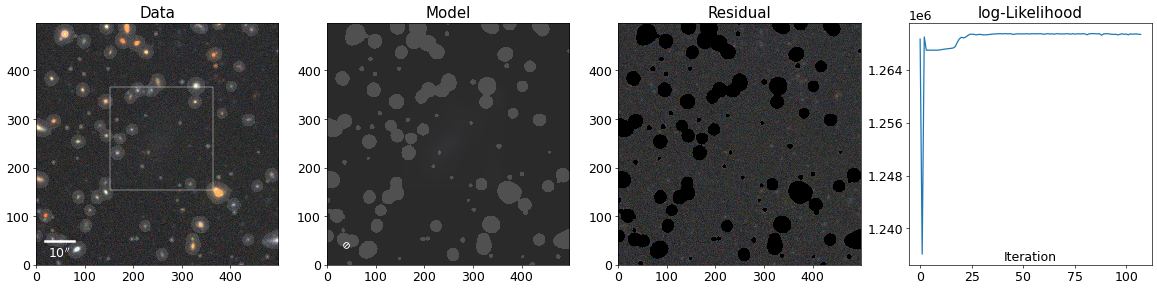

In [664]:
fig = kz.display.display_scarlet_results_tigress(
        fitter._blend,
        #fitter.final_mask,
        show_ind=fitter.sed_ind,
#         zoomin_size=50,
        minimum=-0.2,
        stretch=1,
        Q=1,
        channels=fitter.data.channels,
        show_loss=True,
        show_mask=False,
        show_mark=False,
        scale_bar=True)

In [119]:
morph = fitter.blend.sources[0].morphology

In [120]:
morph.shape

(7, 241, 241)

In [121]:
from scarlet import Starlet

In [122]:
s = Starlet.from_coefficients(morph)

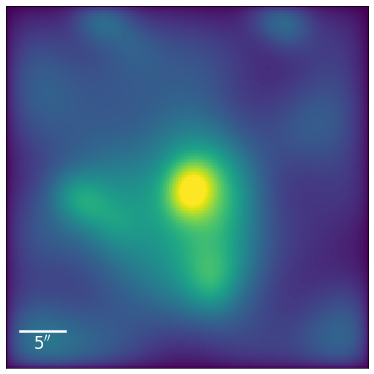

In [123]:
display_single(s.image);

[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

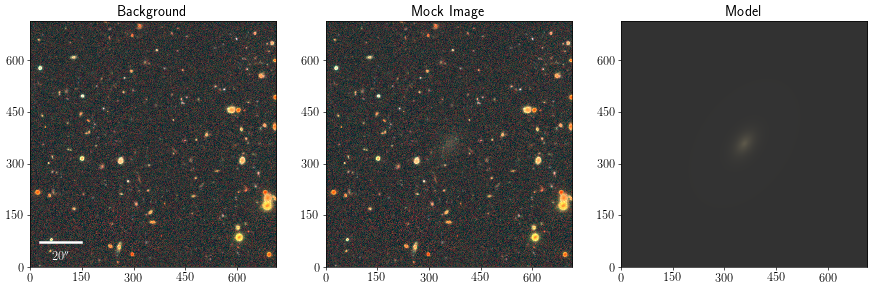

In [19]:
import pickle

with open(f'./Cutout/mock_sample/mock_3.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display()

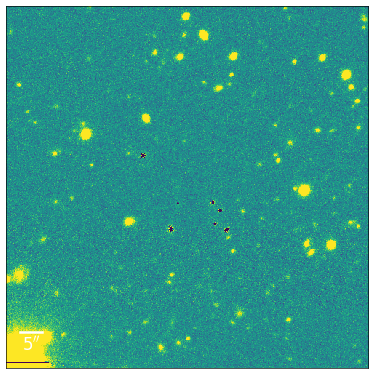

In [176]:
display_single(gal.mock.images[1] - fitter.blend.get_model()[1]);

In [177]:
from kuaizi.measure import makeMeasurement

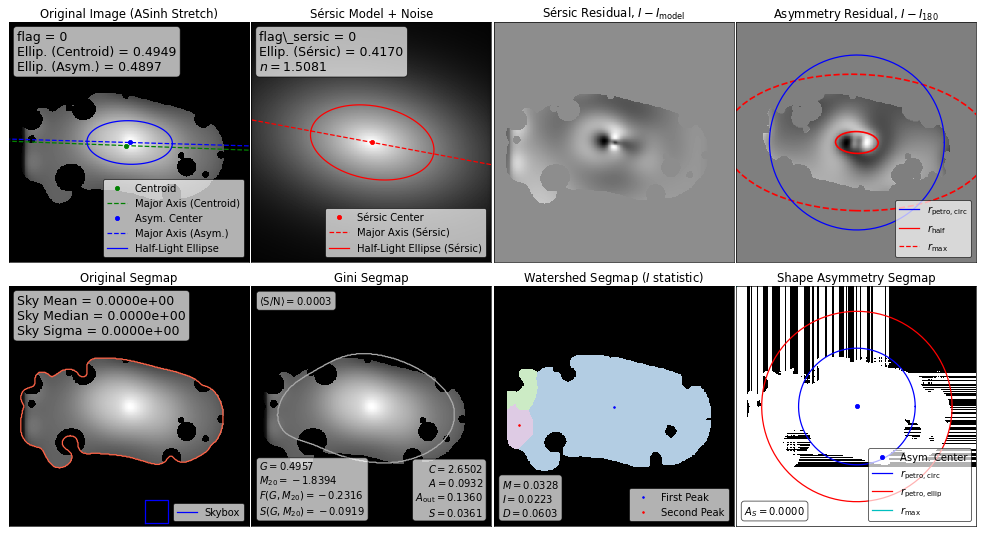

In [181]:
measurement, t = makeMeasurement(list(np.array(fitter.blend.sources)[fitter.sed_ind]),
                                 fitter.blend.observations[0],
                                 #aggr_mask=fitter.final_mask.astype(bool),
                                 makesegmap=True, sigma=0.02,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

In [182]:
measurement['rhalf_circularized'] * 0.168

6.8971733493608935

In [183]:
gal.model.info

{'comp': [{'model': galsim.sersic.Sersic,
   'model_params': {'n': 1.155423302925679,
    'half_light_radius': 6.605138832076752},
   'shear_params': {'q': 0.5006696720493176,
    'beta': coord.Angle(-0.09101297090441032, coord.radians)},
   'sed': array([0.70654856, 0.89796649, 1.        , 1.13465102])}],
 'imag': 20.603578830980503,
 'flux_fraction': [1.0],
 'ra': 135.70169747732143,
 'dec': -0.022698061176389752,
 'gmag': 20.980723785407683,
 'rmag': 20.72042850804205,
 'zmag': 20.466423056808324}

In [746]:
from matplotlib import colors
divnorm = colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)

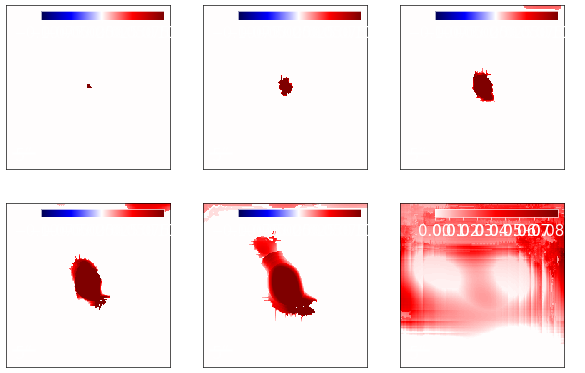

In [747]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i in range(6):
    divnorm = colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
    axes[i//3, i%3] = display_single(morph[i+1], ax=axes[i//3, i%3],
                                     color_bar=True, cmap='seismic', norm=divnorm);

In [94]:
import PIL.Image

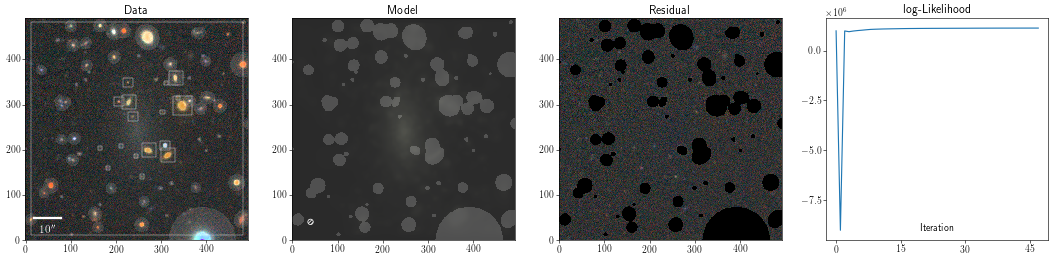

In [148]:
PIL.Image.open('./Figure/mock_sample/mock-911-zoomin-wavelet.png')

In [ ]:
30,56,990

In [22]:
truth_cat[220]

<Row index=220>
viz-id      SB_eff_g           mag_g               ellip              sersic_n             g-i                g-r         rhalf_circularized
int64       float64           float64             float64             float64            float64            float64            float64      
------ ----------------- ------------------ -------------------- ------------------ ------------------ ------------------ ------------------
   220 25.68040668309092 19.233756247465013 0.042998356864001795 0.9852066064739459 0.6609536908170681 0.4722505867581832  7.766764787119815

In [701]:
truth_cat[truth_cat['viz-id'] == 205]

<Table length=1>
viz-id      SB_eff_g      ...        g-r         rhalf_circularized
int64       float64       ...      float64            float64      
------ ------------------ ... ------------------ ------------------
   205 27.225050487249103 ... 0.2001449598054649  11.64123144321038

In [638]:
truth_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth.fits')
truth_cat[(truth_cat['ellip'] > 0.3) & (truth_cat['SB_eff_g'] > 27)]['viz-id'][30:50]

<Column name='viz-id' dtype='int64' length=20>
168
173
177
178
179
182
187
199
200
201
204
205
238
251
257
261
266
268
276
286

In [223]:
fits.open('./Cutout/mock_sample/bkg/mockbkg_1001_r.fits')[1].data.shape

(715, 715)